In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'



/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
def coulombEffect(Z,A,rfrac=0.75):
    alpha=1/137
    hbar=.197
    R=1.1*A**(1/3)+.86*A**(-1/3)
    #if the rfrac is not specified, use 3/4.  
    return (-3*alpha*(Z-1)/(2*R)+alpha*(Z-1)/(2*R)*rfrac)*hbar


0.0
0.0027949112272293956
0.009122575858917641
0.01969718304826887


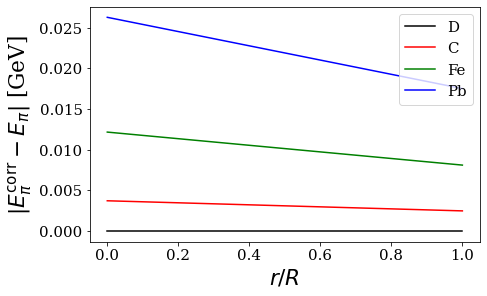

In [3]:
rfrac = np.linspace(0, 1, 101)
for Z, A, name, col in (1, 2, "D", 'k'),(6, 12, "C", 'r'), (26, 56, "Fe", 'g'), (82, 207, "Pb", 'b'):
    plt.plot(rfrac, abs(coulombEffect(Z,A,rfrac)), linestyle='-', label=name, color=col)
    print(abs(coulombEffect(Z,A,0.75)))
plt.xlabel("$r/R$")
plt.ylabel("$|E^{\\rm corr}_{\pi}-E_{\pi}|$ [GeV]")
plt.legend()
plt.show()

In [4]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

In [5]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    dfs_pair['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Get trigger dataframes from deuterium target C


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Getting dataframes from target Fe


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Get trigger dataframes from deuterium target Fe


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Getting dataframes from target Pb


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Get trigger dataframes from deuterium target Pb


/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)
/home/sebouh/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:719: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


CPU times: user 5.6 s, sys: 2.24 s, total: 7.84 s
Wall time: 8.16 s


In [6]:
#mixtag='xQ2_'
#dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}



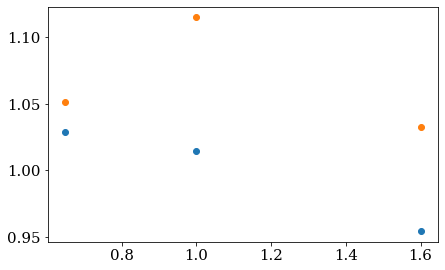

In [7]:
dfs_pair['Pb'].eval('h1_e=nu*h1_z',inplace=True)
dfs_pair['Pb'].eval('h2_e=nu*h2_z',inplace=True)

y1,x=np.histogram(dfs_pair['Pb'].eval("h1_cm_pt*(h1_e-.025)/h1_e"), bins=(.25, .4, .6,1.0))
y2,x=np.histogram(dfs_pair['Pb'].eval("h1_cm_pt"),bins=(.25, .4, .6,1.0))
plt.plot(x[1:]+x[:-1],y1/y2, marker='o', linestyle='')

y1,x=np.histogram(dfs_pair['Pb'].eval("h2_cm_pt*(h2_e+.025)/h2_e"), bins=(.25, .4, .6,0.8))
y2,x=np.histogram(dfs_pair['Pb'].eval("h2_cm_pt"),bins=(.25, .4, .6,1.0))
plt.plot(x[1:]+x[:-1],y1/y2, marker='o', linestyle='')

plt.show()

In [8]:
# import R2h_module
# import imp
# imp.reload(R2h_module)
# for key in list(dfs_mixed.keys()):
#     isMC=False
#     if 'GiBUU' in key:
#         isMC=True
#     dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
#     dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
#     print(f"\n\n{key}")
#     if  'dphi' not in dfs_mixed[key].columns:
#         dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
#     dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
#     dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
#     dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

#     mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
#     dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
#                                                              nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    

In [9]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True)


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
10< h1_th 129258  (100.00  %)
Theta/P fiducial region selected for trigger hadron 129258  (100.00  %)
Nom cuts for the trigger applied 44785  (34.65  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
secondary hadrons are pions 44785  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 35717  (79.75  %)
kinematic limits for h2_z 35636  (99.77  %)
kinematic limits for dphi 35596  (99.89  %)
kinematic limits for pair_mass 35415  (99.49  %)
leading hadrons are pions 35415  (100.00  %)
0.2<h2_p<5.0 35415  (100.00  %)
0.2<h1_p<5.0 35415  (100.00  %)
10<h2_th 35415  (100.00  %)
Theta/P fiducial region selected for secondary hadron 32420  (91.54  %)
10< h1_th 32420  (100.00  %)
Theta/P fiducial region

C pt1 0 0.01539689808623903 0.17984053727786123 0.005867943005050638 -0.06421647479469088
C pt1 1 0.005792397295221766 0.13303452314116662 0.00389979985512059 -0.0029607042397818656
C pt1 2 0.028142717767555996 0.33518143741885575 0.010973446959391365 -0.0006223980592445893
C pt2 0 0.017414199399353094 0.1974064252545618 0.006452722847024019 -0.004867922555627893
C pt2 1 0.010412328164653014 0.19049347532971525 0.009329766139036326 -0.0038679757168463514
C pt2 2 0.024135055045030086 0.33010539789390564 0.02357971923916929 -0.0008854698441511708
C 0.011935542579056066 -0.0031897715495044347
Fe pt1 0 0.061479835594167045 0.4765791602596626 0.013109958484276103 -0.0008854698441511708
Fe pt1 1 0.08880379741067736 0.4409976588650496 0.014300347470969242 0.001693233940887127
Fe pt1 2 0.07704659383655178 0.6435839089812683 0.017692581806140053 -0.011908560606404914
Fe pt2 0 0.06617296367099453 0.5299739644248976 0.01238411982148838 -0.006629396297191616
Fe pt2 1 0.05287991813714733 0.37327718

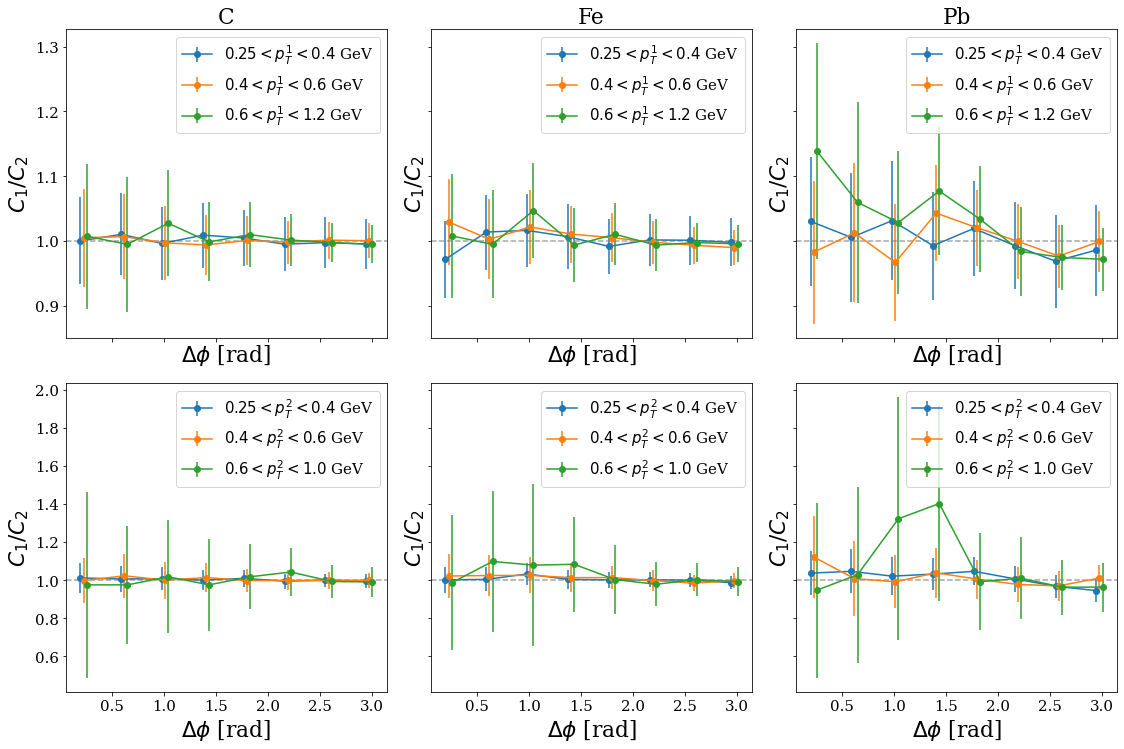

In [25]:
q="h1_pid==211 and h2_pid==-211"
def get_envelope(y1,y2):
    y=y2/sum(y2)
    dy=y1/sum(y1)-y
    n= len(y1)
    
    m = (sum(dy**2*y)*n-sum(dy**2)*sum(y))/(sum(y**2)*n-sum(y)**2)
    b = sum(dy**2)/n-sum(y)/n*m
    return np.sqrt(y*m+b)/y
    #return np.sqrt(np.mean((y1/sum(y1)-y2/sum(y2))**2))/(y1/sum(y1))

fig, axs=plt.subplots(2, 3, figsize=(16, 16*2/3),sharex=True, sharey='row')
    
syst_widths={}
for iax, (A, deltaE) in  enumerate((("C", 0.0028), ("Fe", .0091), ("Pb",.020))): 
    dfs_pair[A].eval('h1_e=nu*h1_z',inplace=True)
    dfs_pair[A].eval('h2_e=nu*h2_z',inplace=True)

    
    pid=211; pT1min=0.25; pT2min=0.25; pMin=0.35
    #q1 = f"h1_pid=={pid}  and h2_z*(h2_e+{deltaE})/h2_e>0.05 and h2_z*(h2_e+{deltaE})/h2_e<0.45 and h1_cm_pt*(h1_e-{deltaE})/h1_e > {pT1min} and "+\
    #             f"h2_cm_pt*(h2_e+{deltaE})/h2_e > {pT2min} and h1_z*(h1_e-{deltaE})/h1_e>0.5 and h2_pid=={-pid} and h2_p*(h2_e+{deltaE})/h2_e>{pMin}"
    
    pid=211; pT1min=0.25; pT2min=0.25; pMin=0.35
    #q2 = f"h1_pid=={pid}  and h2_z>0.05 and h2_z<0.45 and h1_cm_pt > {pT1min} and "+\
    #             f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid=={-pid} and h2_p>{pMin}"
    plt.sca(axs[0][iax])
    plt.title(A)
    bins=(.25, .4, .6,1.2)
    sumDev2s=0
    syst_width_sum=0
    for i in range(3):
        col = 'tab:blue tab:orange tab:green'.split()[i]
        cuts = f"h2_cm_pt*(h2_e+{deltaE})/h2_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h1_cm_pt*(h1_e-{deltaE})/h1_e>{bins[i]} and h1_cm_pt*(h1_e-{deltaE})/h1_e<{bins[i+1]}"
        cuts = f"h2_cm_pt*(h2_e+{deltaE})/h2_e>.25 and h1_z>.5 and h1_cm_pt*(h1_e-{deltaE})/h1_e>{bins[i]} and h1_cm_pt*(h1_e-{deltaE})/h1_e<{bins[i+1]}"
        
        df_slice = dfs_pair[A].query(q).query(cuts)

        y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        cuts = f"h2_cm_pt>.25  and h1_z>0.5 and h1_cm_pt>{bins[i]} and h1_cm_pt<{bins[i+1]}"
        df_slice = dfs_pair[A].query(q).query(cuts)
        y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        x=(x[1:]+x[:-1])/2

        r = y1/sum(y1)/(y2/sum(y2))
        dr = r*np.sqrt(1/y1)
        sumDev2s+=sum((r-1)**2)
        print(A,"pt1", i,  sum((r-1)**2/dr**2)/7, max(abs(r-1)/dr),np.sqrt(sum((r-1)**2)/8), syst_width)
        
        plt.errorbar(x+i*.03,r, dr, color=col, marker='o',label=f'${bins[i]:.2}<p^1_T<{bins[i+1]:2}$ GeV')
        syst_width=(sum(y2*(x-np.pi)*(x-np.pi))/sum(y2)-sum(y1*(x-np.pi)*(x-np.pi))/sum(y1))/(sum(y1*(x-np.pi)*(x-np.pi))/sum(y1))
        syst_widths[A,"pT1",i]=syst_width
        syst_width_sum+=syst_width
        #env=get_envelope(y1,y2)
        #plt.fill_between(x, 1-env, 1+env, color=col, alpha=0.2)
        #print(np.sqrt(np.mean((r-1)**2)), min(dr), np.sum((r-1)**2/dr**2))
    #print(A, np.sqrt(sumDev2s/24))
    plt.axhline(1, color='0.5', alpha=0.7, linestyle='--')
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.legend()
    plt.ylabel("$C_1/C_2$")
    plt.sca(axs[1][iax])
    bins=(.25, .4, .6,1.0)
    for i in range(3):
        col = 'tab:blue tab:orange tab:green'.split()[i]
        cuts = f"h1_cm_pt*(h1_e-{deltaE})/h1_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h2_cm_pt*(h2_e+{deltaE})/h2_e>{bins[i]} and h2_cm_pt*(h2_e+{deltaE})/h2_e<{bins[i+1]}"
        cuts = f"h1_cm_pt*(h1_e-{deltaE})/h1_e>.25 and h1_z>.5 and h2_cm_pt*(h2_e+{deltaE})/h2_e>{bins[i]} and h2_cm_pt*(h2_e+{deltaE})/h2_e<{bins[i+1]}"
        
        df_slice = dfs_pair[A].query(q).query(cuts)

        y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        cuts = f"h1_cm_pt>.25  and h1_z>0.5 and h2_cm_pt>{bins[i]} and h2_cm_pt<{bins[i+1]}"
        df_slice = dfs_pair[A].query(q).query(cuts)
        y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        x=(x[1:]+x[:-1])/2
        r = y1/sum(y1)/(y2/sum(y2))
        dr = r*np.sqrt(1/y1+1/y2)
        sumDev2s+=sum((r-1)**2)
        syst_width=(sum(y2*(x-np.pi)*(x-np.pi))/sum(y2)-sum(y1*(x-np.pi)*(x-np.pi))/sum(y1))/(sum(y1*(x-np.pi)*(x-np.pi))/sum(y1))
        
        syst_widths[A,"pT2",i]=syst_width                                                                                  
        print(A,"pt2", i,  sum((r-1)**2/dr**2)/7, max(abs(r-1)/dr),np.sqrt(sum((r-1)**2)/8), syst_width)
        #print(np.sqrt(np.mean((r-1)**2)), min(dr), np.sum((r-1)**2/dr**2))
        plt.errorbar(x+i*.03,r, dr, color=col, marker='o',label=f'${bins[i]:.2}<p^2_T<{bins[i+1]:2}$ GeV')
        #env=get_envelope(y1,y2)
        #plt.fill_between(x, 1-env, 1+env, color=col, alpha=0.2)
        syst_width_sum+=syst_width
    syst_width_sum/=6
    print(A,np.sqrt(sumDev2s/48), syst_width_sum)
    plt.axhline(1, color='0.5', alpha=0.7, linestyle='--')
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.ylabel("$C_1/C_2$")
    plt.legend()
plt.tight_layout()
plt.show()

import pickle
with open("syst_from_coulomb_widths.pkl", "wb") as f:
    pickle.dump(syst_widths, f, pickle.HIGHEST_PROTOCOL)

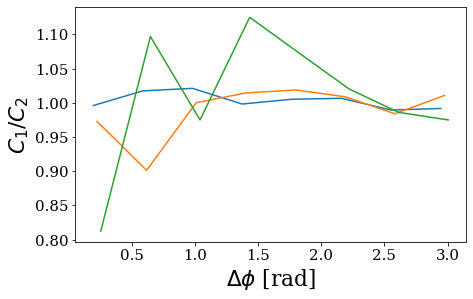

In [46]:
dfs_pair['Pb'].eval('h1_e=nu*h1_z',inplace=True)
dfs_pair['Pb'].eval('h2_e=nu*h2_z',inplace=True)

bins=(.25, .4, .6,0.8)
for i in range(3):
    cuts = f"h1_cm_pt*(h1_e+{deltaE})/h1_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h2_cm_pt*(h1_e+{deltaE})/h1_e>{bins[i]} and h2_cm_pt*(h1_e+{deltaE})/h1_e<{bins[i+1]}"
    df_slice = dfs_pair['Pb'].query(cuts)
    
    y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9), density=True)
    cuts = f"h1_cm_pt>.25  and h1_z>0.5 and h2_cm_pt>{bins[i]} and h2_cm_pt<{bins[i+1]}"
    df_slice = dfs_pair['Pb'].query(cuts)
    y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9), density=True)
    x=(x[1:]+x[:-1])/2
    plt.errorbar(x+i*.03,y1/y2)
plt.xlabel("$\Delta\phi$ [rad]")
plt.ylabel("$C_1/C_2$")
plt.show()